
#Brendon

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import string, os
import re
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import pickle

#Initializing TPU in case we have a big Dataset

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.__version__)

Number of replicas: 1
2.5.0


#Hyperparameters

In [ ]:
batch_size = 10  # Batch size to train my dataset
epochs = 30  # Number of epochs to train fmy dataset
latent_dim = 251  # Latent dimensionality of the encoding space
num_samples = 189 # Number of sample

In [ ]:
#Mounting my drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data obtained on github as a json file and l converted it to csv for readability so that l obtain good results

link https://github.com/PuneetShivaay/Deep-Learning-Based-Chatbot-For-Medical-Assistance

In [ ]:
# reading dataset
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/health/Healthcare.csv')
df.head()

,conversation_id,message,sentiment
0,1,greeting,greeting
1,1,Hi there,greeting
2,1,How are you,greeting
3,1,Is anyone there?,greeting
4,1,Hola,greeting


## Preprocessing of my data




In [ ]:
# Preprocessing and cleaning text
def process(text):
    text = text.lower().replace('\n', ' ').replace('-', ' ').replace(':', ' ').replace(',', '') \
          .replace('"', ' ').replace(".", " ").replace("!", " ").replace("?", " ").replace(";", " ").replace(":", " ")

    text = "".join(v for v in text if v not in string.punctuation).lower()
    #text = text.encode("utf8").decode("ascii",'ignore')

    text = " ".join(text.split())
    #text+="<eos>"
    return text

In [ ]:
df.message = df.message.apply(process)

In [ ]:
df.head()

,conversation_id,message,sentiment
0,1,greeting,greeting
1,1,hi there,greeting
2,1,how are you,greeting
3,1,is anyone there,greeting
4,1,hola,greeting


# Preprocessing techniques on splitting and refining my data

In [ ]:
# Vectorize the data.
input_texts = []
target_texts = []
input_words_set = set()
target_words_set = set()

for conversation_index in tqdm(range(df.shape[0])):

    if conversation_index == 0:
        continue

    input_text = df.iloc[conversation_index - 1]
    target_text = df.iloc[conversation_index]

    if input_text.conversation_id == target_text.conversation_id:

        input_text = input_text.message
        target_text = target_text.message

        if len(input_text.split()) > 2 and \
            len(target_text.split()) > 0 and \
            len(input_text.split()) < 30 and \
            len(target_text.split()) < 10 and \
            input_text and \
            target_text:

            target_text = "bos " + target_text + " eos"

            input_texts.append(input_text)
            target_texts.append(target_text)

            for word in input_text.split():
                if word not in input_words_set:
                    input_words_set.add(word)
            for word in target_text.split():
                if word not in target_words_set:
                    target_words_set.add(word)

100%|██████████| 414/414 [00:00<00:00, 2907.54it/s]


# Tokenization

In [ ]:
input_words = sorted(list(input_words_set))
target_words = sorted(list(target_words_set))
num_encoder_tokens = len(input_words)
num_decoder_tokens = len(target_words)
max_encoder_seq_length = max([len(txt.split()) for txt in input_texts])
max_decoder_seq_length = max([len(txt.split()) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(word, i) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i) for i, word in enumerate(target_words)])

#saving
with open('input_token_index.pickle', 'wb') as handle:
    pickle.dump(input_token_index, handle, protocol=pickle.HIGHEST_PROTOCOL)

#saving
with open('target_token_index.pickle', 'wb') as handle:
    pickle.dump(target_token_index, handle, protocol=pickle.HIGHEST_PROTOCOL)


encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):

    for t, word in enumerate(input_text.split()):
        encoder_input_data[i, t] = input_token_index[word]

    for t, word in enumerate(target_text.split()):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t] = target_token_index[word]
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[word]] = 1.0

Number of samples: 189
Number of unique input tokens: 297
Number of unique output tokens: 266
Max sequence length for inputs: 12
Max sequence length for outputs: 11


#Seq2seq model and Adam Optimization using AdaGrad and RMSProp

In [ ]:
embedding_size = 100

# seq2seq model
with strategy.scope():
    # Define an input sequence and process it.
    encoder_inputs = keras.Input(shape=(None,))

    encoder_embedding_output = keras.layers.Embedding(num_encoder_tokens, embedding_size)(encoder_inputs)

    encoder = keras.layers.LSTM(latent_dim, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_embedding_output)

    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]

    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = keras.Input(shape=(None,))

    decoder_embedding = keras.layers.Embedding(num_decoder_tokens, embedding_size)
    decoder_embedding_output = decoder_embedding(decoder_inputs)


    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding_output, initial_state=encoder_states)
    decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    model.summary()

 #Modeling Evaluation

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    29700       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    26600       input_2[0][0]                    
______________________________________________________________________________________________

# Training my dataset


In [ ]:
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=20,
    validation_split=0.1,
)

Epoch 1/20
17/17 [==============================] - 5s 117ms/step - loss: 2.5165 - accuracy: 0.0856 - val_loss: 2.5194 - val_accuracy: 0.0909
Epoch 2/20
17/17 [==============================] - 1s 67ms/step - loss: 2.2175 - accuracy: 0.1000 - val_loss: 2.4271 - val_accuracy: 0.0957
Epoch 3/20
17/17 [==============================] - 1s 67ms/step - loss: 2.1467 - accuracy: 0.1048 - val_loss: 2.4186 - val_accuracy: 0.0957
Epoch 4/20
17/17 [==============================] - 1s 68ms/step - loss: 2.1109 - accuracy: 0.1112 - val_loss: 2.3750 - val_accuracy: 0.0957
Epoch 5/20
17/17 [==============================] - 1s 66ms/step - loss: 2.0929 - accuracy: 0.1064 - val_loss: 2.3590 - val_accuracy: 0.0957
Epoch 6/20
17/17 [==============================] - 1s 66ms/step - loss: 2.0601 - accuracy: 0.1123 - val_loss: 2.3310 - val_accuracy: 0.0957
Epoch 7/20
17/17 [==============================] - 1s 67ms/step - loss: 2.0201 - accuracy: 0.1150 - val_loss: 2.2834 - val_accuracy: 0.0957
Epoch 8/20
1

#Visualization and Plotting

In [ ]:
model.save('Health.h5')

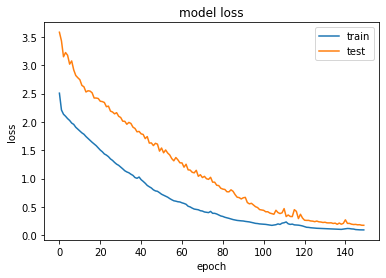

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
# Save model
model.save("s2s.hdf5")

#DNN architextures, picking the right model for the problem

In [ ]:
# define the encoder model
encoder_model = keras.Model(encoder_inputs, encoder_states)
encoder_model.summary()

decoder_state_input_h = keras.Input(shape=(None,))
decoder_state_input_c = keras.Input(shape=(None,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_embedding_output = decoder_embedding(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(decoder_embedding_output, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)
# Reverse-lookup token index to decode sequences back
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_18 (Embedding)     (None, None, 100)         29700     
_________________________________________________________________
lstm_18 (LSTM)               [(None, 251), (None, 251) 353408    
Total params: 383,108
Trainable params: 383,108
Non-trainable params: 0
_________________________________________________________________


In [ ]:
encoder_model.save("encoder_model.hdf5")
decoder_model.save("decoder_model.hdf5")

#Response function

In [ ]:
def respond(text):
    input_seq = np.zeros(
        (1, max_encoder_seq_length), dtype="float32"
    )

    for t, word in enumerate(text.split()):
        input_seq[0, t] = input_token_index[word]

    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['bos']
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == 'eos' or
           len(decoded_sentence) > 50):
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_char

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        # Update states
        states_value = [h, c]
    return decoded_sentence

#Transformation and Normalization



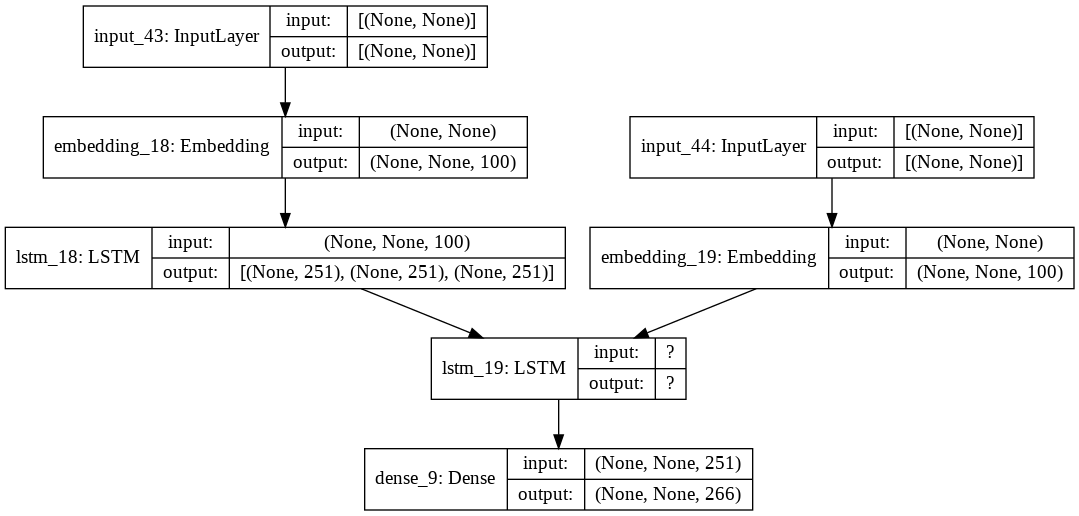

In [ ]:
#from tensorflow.keras.utils import plot_model
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='/content/drive/My Drive/Colab Notebooks/health/DoctorAppointment.png', show_shapes=True, show_layer_names=True)



#Chatting with my Healthcare bot, we will call her TeeKay

In [ ]:
respond("have a problem") #it will respond according to the input

' you might be suffering from chickenpox'

In [ ]:
respond("name") #asking you name, so that the friendship will increase from small talks

' what should i call you'

In [ ]:
respond(" bye") #saying goodbye to the bot

' goodbye'

In [ ]:
respond("can you help me") #asking for help

' yes i can help you'

#Decoding the training set

In [ ]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    decoded_sentence = respond(input_texts[seq_index])
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

-
Input sentence: how are you
Decoded sentence:  is anyone there
-
Input sentence: is anyone there
Decoded sentence:  hola
-
Input sentence: hello thanks for asking
Decoded sentence:  good to see you again
-
Input sentence: good to see you again
Decoded sentence:  hi there how can i help
-
Input sentence: what is your name
Decoded sentence:  what should i call you
-
Input sentence: what should i call you
Decoded sentence:  whats your name
-
Input sentence: whats your name
Decoded sentence:  you can call me doctor brendon
-
Input sentence: you can call me doctor brendon
Decoded sentence:  im engineer teekay
-
Input sentence: see you later
Decoded sentence:  goodbye
-
Input sentence: nice chatting to you bye
Decoded sentence:  till next time
-
Input sentence: till next time
Decoded sentence:  see you
-
Input sentence: have a nice day
Decoded sentence:  bye come back again soon
-
Input sentence: i need help
Decoded sentence:  help me
-
Input sentence: i have some problem
Decoded sentence:

In [ ]:
eos_token = target_token_index['eos']
eos_token

89

#Beaming my text in the Dataset

In [ ]:
from math import log
def generate_beam_text(seed_text, next_words, beam_search_n, break_at_eos):

    distributions_scores_states = [[list(), 0.0, [None, None]]]

    decoder_states_value = None

    for _ in range(next_words):

        sequence_temp_candidates = list()

        for i in range(len(distributions_scores_states)):

            input_seq = np.zeros(
                (1, max_encoder_seq_length), dtype="float32"
            )

            # Generate empty target sequence of length 1.
            target_seq = np.zeros((1,1))

            seq, score, states_values = distributions_scores_states[i]

            if len(distributions_scores_states) == 1:
                for t, word in enumerate(process(seed_text).split()):
                    input_seq[0, t] = input_token_index[word]

                # Encode the input as state vectors.
                decoder_states_value = encoder_model.predict(input_seq)

                # Populate the first character of target sequence with the start character.
                target_seq[0, 0] = target_token_index['bos']

            else:
                target_seq[0, 0] = seq[-1]
                decoder_states_value = states_values

                candidate_sentence = ""
                for token_index in seq:
                    if token_index == eos_token:
                        break

                    word = reverse_target_char_index[token_index]
                    candidate_sentence+=word + " "

                print("score :", score, " | ", candidate_sentence)


            output_tokens_distribution, h, c = decoder_model.predict([target_seq] + decoder_states_value)

            # Update states
            decoder_states_value = [h, c]

            predicted_distribution = output_tokens_distribution[0][0]

            for j in range(len(predicted_distribution)):
                if predicted_distribution[j] > 0:
                    candidate = [seq + [j], score - log(predicted_distribution[j]), decoder_states_value]
                    if break_at_eos and j == eos_token:
                        continue
                    else:
                        sequence_temp_candidates.append(candidate)


        # 2. score and sort all candidates
        ordered = sorted(sequence_temp_candidates, key=lambda tup:tup[1])

        distributions_scores_states = ordered[:beam_search_n]

        print("-----")

In [ ]:
generate_beam_text("you might", 4, 5, False)

-----
score : 1.1961983327362133  |  headache 
score : 1.5791023803138544  |  problem 
score : 1.9382636909266382  |  goodbye 
score : 2.085053299861349  |  hola 
score : 2.2958077279747373  |  sweating 
-----
score : 1.2528619821451679  |  headache 
score : 1.6143567704410982  |  problem 
score : 1.9819781666485714  |  goodbye 
score : 2.1288829157815456  |  hola 
score : 2.3358149833195485  |  sweating 
-----
score : 5.161549830542  |  headache 
score : 5.3692829143967  |  headache 
score : 5.520416289104486  |  problem 
score : 5.711537610766459  |  headache 
score : 5.720031734981889  |  problem 
-----


In [ ]:
generate_beam_text("thanks", 5, 5, False)

-----
score : 1.0916492240669768  |  problem 
score : 1.1046496819599645  |  headache 
score : 1.971165808137952  |  goodbye 
score : 3.110631211811256  |  sweating 
score : 3.141698076310022  |  hola 
-----
score : 1.1289974876666458  |  problem 
score : 1.1681679107845218  |  headache 
score : 2.0260598756467916  |  goodbye 
score : 3.1528613860251173  |  sweating 
score : 3.1886711728409587  |  hola 
-----
score : 5.03343523554741  |  problem 
score : 5.071866873366145  |  headache 
score : 5.228869745652742  |  problem 
score : 5.285032130098537  |  headache 
score : 5.601733595750873  |  problem 
-----
score : 5.387202516526233  |  problem 
score : 5.443648731093784  |  headache 
score : 5.670718288662511  |  problem 
score : 8.823725958807758  |  problem 
score : 8.8778833639774  |  headache 
-----


In [ ]:
generate_beam_text("tell me what can i do for you", 5, 5, False)

-----
score : 0.05757247133866767  |  what 
score : 3.867943831247506  |  blurred 
score : 4.308777940911542  |  how 
score : 5.063408999273781  |  you 
score : 5.520508929901297  |  itchiness 
-----
score : 0.07563217642050574  |  what do 
score : 3.932047889181042  |  blurred vision 
score : 4.464099981473815  |  how can 
score : 5.219939611667593  |  you might 
score : 5.2981968756127715  |  what should 
-----
score : 0.10709001560851163  |  what do you 
score : 3.9939430158901272  |  blurred vision 
score : 4.671544082161159  |  how can i 
score : 4.832691175785236  |  what do do 
score : 5.281588989682012  |  you might be 
-----
score : 0.1960305847378265  |  what do you want 
score : 4.006455418518774  |  what do you need 
score : 4.394150684222454  |  what do you call 
score : 4.483506172156938  |  what do you might 
score : 4.9160623603430045  |  what do you do 
-----
